In [41]:
!pip install google-api-python-client


In [42]:
!pip install google-api-python-client transformers matplotlib


In [47]:
!pip install python-dotenv

In [76]:
import os
from dotenv import load_dotenv
import re
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from transformers import pipeline
import random

In [49]:
load_dotenv('/content/drive/MyDrive/1.env')
youtube_api_key = os.getenv('youtube_api_key')

# –ó–∞–º–µ–Ω–∏—Ç–µ –Ω–∞ –≤–∞—à API-–∫–ª—é—á
API_KEY = youtube_api_key
# –°–æ–∑–¥–∞–µ–º –æ–±—ä–µ–∫—Ç –¥–ª—è —Ä–∞–±–æ—Ç—ã —Å API YouTube
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [50]:
# –ò–∑–≤–ª–µ–∫–∞–µ–º –≤–∏–¥–µ–æ
def extract_video_id(url):
    """
    –ò–∑–≤–ª–µ–∫–∞–µ—Ç video_id –∏–∑ URL YouTube.

    –ü–æ–¥–¥–µ—Ä–∂–∏–≤–∞–µ–º—ã–µ —Ñ–æ—Ä–º–∞—Ç—ã URL:
      - https://www.youtube.com/watch?v=VIDEO_ID
      - https://youtu.be/VIDEO_ID
      - https://www.youtube.com/embed/VIDEO_ID
    """
    patterns = [
        r'(?:v=)([0-9A-Za-z_-]{11})',        # —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π URL
        r'(?:youtu\.be/)([0-9A-Za-z_-]{11})', # —Å–æ–∫—Ä–∞—â—ë–Ω–Ω—ã–π URL
        r'(?:embed/)([0-9A-Za-z_-]{11})'       # embed-–≤–µ—Ä—Å–∏—è
    ]
    for pattern in patterns:
        match = re.search(pattern, url)
        if match:
            return match.group(1)
    return None

In [56]:
# –ò–∑–≤–ª–µ–∫–∞–µ–º –Ω–∞–∑–≤–∞–Ω–∏–µ –≤–∏–¥–µ–æ
def get_video_title(video_id):
    """
    –ü–æ–ª—É—á–∞–µ—Ç –Ω–∞–∑–≤–∞–Ω–∏–µ –≤–∏–¥–µ–æ –ø–æ –µ–≥–æ ID, –∏—Å–ø–æ–ª—å–∑—É—è YouTube Data API.

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
      - title (str): –Ω–∞–∑–≤–∞–Ω–∏–µ –≤–∏–¥–µ–æ, –µ—Å–ª–∏ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –ø–æ–ª—É—á–µ–Ω–∞,
        –∏–ª–∏ —Å–æ–æ–±—â–µ–Ω–∏–µ –æ–± –æ—à–∏–±–∫–µ, –µ—Å–ª–∏ –¥–∞–Ω–Ω—ã–µ –Ω–µ–¥–æ—Å—Ç—É–ø–Ω—ã.
    """
    response = youtube.videos().list(
        part='snippet',
        id=video_id
    ).execute()

    items = response.get("items", [])
    if items:
        title = items[0]["snippet"]["title"]
        return title
    else:
        return "–ù–µ —É–¥–∞–ª–æ—Å—å –ø–æ–ª—É—á–∏—Ç—å –Ω–∞–∑–≤–∞–Ω–∏–µ –≤–∏–¥–µ–æ."

In [51]:
# –ò–∑–≤–ª–µ–∫–∞–µ–º –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏
def get_comments(video_id):
    """
    –ü–æ–ª—É—á–∞–µ—Ç –≤—Å–µ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ –¥–ª—è —É–∫–∞–∑–∞–Ω–Ω–æ–≥–æ –≤–∏–¥–µ–æ –ø–æ –µ–≥–æ ID.

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
      - comments (list): —Å–ø–∏—Å–æ–∫ —Ç–µ–∫—Å—Ç–æ–≤ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤.
    """
    comments = []
    next_page_token = None

    while True:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat="plainText",
            maxResults=100,
            pageToken=next_page_token
        ).execute()

        for item in response.get('items', []):
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return comments


In [68]:
def analyze_sentiments(comments):
    """
    –ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ—Ç —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å —Å–ø–∏—Å–∫–∞ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ —Å –ø–æ–º–æ—â—å—é –º–æ–¥–µ–ª–∏,
    –∞–¥–∞–ø—Ç–∏—Ä–æ–≤–∞–Ω–Ω–æ–π –¥–ª—è —Ä—É—Å—Å–∫–æ–≥–æ —è–∑—ã–∫–∞.

    –ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –º–æ–¥–µ–ª—å "blanchefort/rubert-base-cased-sentiment" –∏–∑ Hugging Face.

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
      - sentiment_results (list): —Å–ø–∏—Å–æ–∫ —Å–ª–æ–≤–∞—Ä–µ–π, –≥–¥–µ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏—è —É–∫–∞–∑–∞–Ω—ã:
          - 'comment': —Å–∞–º –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π,
          - 'label': –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è (–Ω–∞–ø—Ä–∏–º–µ—Ä, Positive, Neutral, Negative),
          - 'score': —É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏.
    """
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="blanchefort/rubert-base-cased-sentiment",
        tokenizer="blanchefort/rubert-base-cased-sentiment"
    )

    sentiment_results = []
    for comment in comments:
        # –ò—Å–ø–æ–ª—å–∑—É–µ–º truncation=True, —á—Ç–æ–±—ã –æ–±—Ä–µ–∑–∞—Ç—å –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏, –µ—Å–ª–∏ –æ–Ω–∏ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã–µ
        result = sentiment_pipeline(comment, truncation=True)[0]
        sentiment_results.append({
            'comment': comment,
            'label': result['label'],
            'score': result['score']
        })
    return sentiment_results

–í–≤–µ–¥–∏—Ç–µ —Å—Å—ã–ª–∫—É –Ω–∞ YouTube –≤–∏–¥–µ–æ: https://www.youtube.com/watch?v=CHDFQVww-0Q&ab_channel=%D0%9F%D0%BE%D0%B4%D0%BA%D0%B0%D1%81%D1%82%D0%93%D0%BB%D0%B5%D0%B1%D0%B0%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B8%D0%BD%D0%B0
–ò–∑–≤–ª–µ—á–µ–Ω–Ω—ã–π video_id: CHDFQVww-0Q
–ù–∞–∑–≤–∞–Ω–∏–µ –≤–∏–¥–µ–æ: –ü–û–¢–û–ú –ë–£–î–ï–¢ –ü–û–ó–î–ù–û! 10 –ø—Ä–∞–≤–∏–ª –æ—Ç –ë–∏–æ—Ö–∞–∫–µ—Ä–∞ ‚Ññ1 –í–∞–¥–∏–º–∞ –ö–∞—Å–ø–∞—Ä–æ–≤–∞
–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤: 359



Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


–ê–≥—Ä–µ–≥–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏:
–ü–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤: 137 (38.16%)
–ù–µ–π—Ç—Ä–∞–ª—å–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤: 133 (37.05%)
–ù–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤: 89 (24.79%)



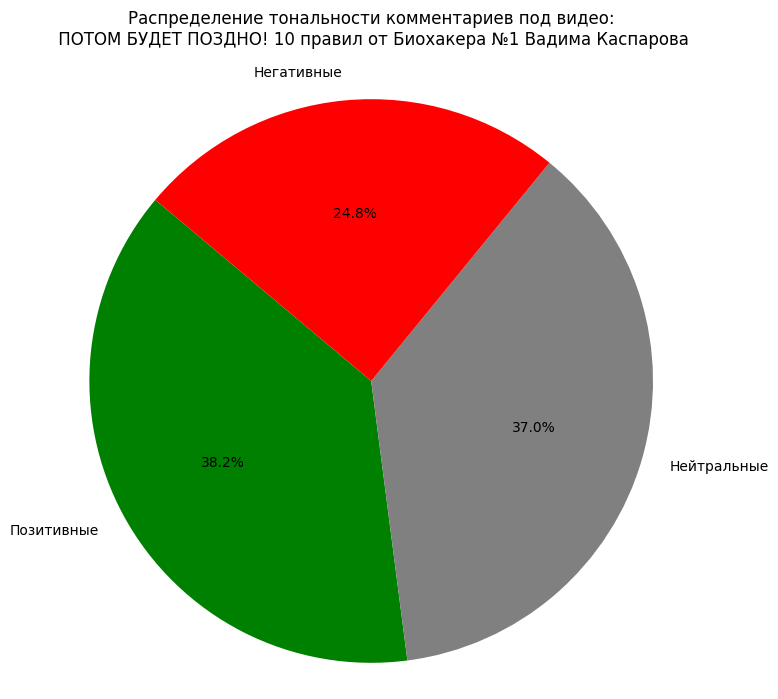

–ü—Ä–∏–º–µ—Ä—ã –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤:

–ü–æ–∑–∏—Ç–∏–≤–Ω—ã–π –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π:
–í–ø–µ—Ä–≤—ã–µ —É–≤–∏–¥–µ–ª –ì–ª–µ–±–∞ –±–ª–∞–≥–æ–¥–∞—Ä—è –ú–∞—Ä–∫–∞—Ä—è–Ω—É. –ö–∞–Ω–∞–ª —Ä–∞—Å—Ç–µ—Ç —Å—Ç—Ä–µ–º–∏—Ç–µ–ª—å–Ω–æ, –∏ –ì–ª–µ–±, –Ω–∞ –º–æ–π –≤–∑–≥–ª—è–¥, –≥–æ—Ä–∞–∑–¥–æ –ª—É—á—à–µ –±–æ–ª–µ–µ –∏–∑–≤–µ—Å—Ç–Ω—ã—Ö –∏–Ω—Ç–µ—Ä–≤—å—é–µ—Ä–æ–≤. –ò—Å–∫—Ä–µ–Ω–Ω–æ—Å—Ç—å –ø–æ–¥–∫—É–ø–∞–µ—Ç. –ù–∏–∫–∞–∫–æ–≥–æ —á—Å–≤, –∫–∞–∫ —É –±–æ–ª–µ–µ –∏–º–µ–Ω–∏—Ç—ã—Ö. –ñ–¥–µ–º 1–º–ª–Ω –ø–æ–¥–ø–∏—Å—á–∏–∫–æ–≤. –°–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–¥–∫–∞—Å—Ç—ã. –û—Ç –ø–æ–±–µ–¥—ã –∫ –ø–æ–±–µ–¥–µüèÜ

–ù–µ–π—Ç—Ä–∞–ª—å–Ω—ã–π –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π:
–ì–ª–µ–± –º–∏–Ω–æ–∫—Å–∏–¥–∏–ª–æ–º –±–∞–ª—É–µ—Ç—Å—è?

–ù–µ–≥–∞—Ç–∏–≤–Ω—ã–π –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π:
–ö–∞—Å–ø–∞—Ä–æ–≤ —É–≤–∞–∂–∞–µ–º—ã–π —á–µ–ª–æ–≤–µ–∫, –Ω–æ –ø–æ–¥–∫–∞—Å—Ç –ø–æ–ª—É—á–∏–ª—Å—è —Å–∫—É—á–Ω—ã–º, –∏–±–æ –≥–æ–≤–æ—Ä–∏–ª–∏ –ø—Ä–æ –∫–∞–∫—É—é-—Ç–æ –±–∞–Ω–∞–ª—å—â–∏–Ω—É, –ø—Ä–æ –∫–æ—Ç–æ—Ä—É—é —É–∂–µ –≤—Å–µ –¥–∞–≤–Ω—ã–º –¥–∞–≤–Ω–æ –∑–Ω–∞—é—Ç


In [77]:
if __name__ == '__main__':
    # –ó–∞–ø—Ä–∞—à–∏–≤–∞–µ–º —É –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è —Å—Å—ã–ª–∫—É –Ω–∞ YouTube –≤–∏–¥–µ–æ
    url = input("–í–≤–µ–¥–∏—Ç–µ —Å—Å—ã–ª–∫—É –Ω–∞ YouTube –≤–∏–¥–µ–æ: ")
    video_id = extract_video_id(url)

    if not video_id:
        print("–ù–µ —É–¥–∞–ª–æ—Å—å –∏–∑–≤–ª–µ—á—å video_id –∏–∑ —Å—Å—ã–ª–∫–∏. –ü—Ä–æ–≤–µ—Ä—å—Ç–µ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ—Å—Ç—å URL.")
    else:
        print("–ò–∑–≤–ª–µ—á–µ–Ω–Ω—ã–π video_id:", video_id)
        video_title = get_video_title(video_id)
        print("–ù–∞–∑–≤–∞–Ω–∏–µ –≤–∏–¥–µ–æ:", video_title)
        all_comments = get_comments(video_id)
        print(f"–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤: {len(all_comments)}\n")

        # –ê–Ω–∞–ª–∏–∑ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ –∫–∞–∂–¥–æ–≥–æ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏—è —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –º–æ–¥–µ–ª–∏ –¥–ª—è —Ä—É—Å—Å–∫–æ–≥–æ —è–∑—ã–∫–∞
        sentiment_results = analyze_sentiments(all_comments)

        # –ê–≥—Ä–µ–≥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∞–Ω–∞–ª–∏–∑: —Å—á–∏—Ç–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º
        pos_count = 0
        neu_count = 0
        neg_count = 0

        # –ü–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –ø—Ä–∏–º–µ—Ä–æ–≤ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤
        pos_comments = []
        neu_comments = []
        neg_comments = []


        for result in sentiment_results:
            label = result['label'].lower()
            if 'positive' in label or '–ø–æ–∑–∏—Ç–∏–≤' in label:
                pos_count += 1
                pos_comments.append(result['comment'])
            elif 'negative' in label or '–Ω–µ–≥–∞—Ç–∏–≤' in label:
                neg_count += 1
                neg_comments.append(result['comment'])
            elif 'neutral' in label or '–Ω–µ–π—Ç—Ä–∞–ª—å' in label:
                neu_count += 1
                neu_comments.append(result['comment'])

        total = pos_count + neu_count + neg_count
        print("–ê–≥—Ä–µ–≥–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏:")
        print(f"–ü–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤: {pos_count} ({pos_count / total * 100:.2f}%)")
        print(f"–ù–µ–π—Ç—Ä–∞–ª—å–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤: {neu_count} ({neu_count / total * 100:.2f}%)")
        print(f"–ù–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤: {neg_count} ({neg_count / total * 100:.2f}%)\n")


        # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è: –ö—Ä—É–≥–æ–≤–∞—è –¥–∏–∞–≥—Ä–∞–º–º–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏
        labels = ['–ü–æ–∑–∏—Ç–∏–≤–Ω—ã–µ', '–ù–µ–π—Ç—Ä–∞–ª—å–Ω—ã–µ', '–ù–µ–≥–∞—Ç–∏–≤–Ω—ã–µ']
        sizes = [pos_count, neu_count, neg_count]
        colors = ['green', 'grey', 'red']

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –ø–æ–¥ –≤–∏–¥–µ–æ:\n {video_title}\n')
        plt.axis('equal')  # —á—Ç–æ–±—ã –∫—Ä—É–≥–æ–≤–∞—è –¥–∏–∞–≥—Ä–∞–º–º–∞ –±—ã–ª–∞ –∫—Ä—É–≥–ª–æ–π
        plt.show()

        # –í—ã–≤–æ–¥ –ø—Ä–∏–º–µ—Ä–æ–≤ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –¥–ª—è –∫–∞–∂–¥–æ–π –∫–∞—Ç–µ–≥–æ—Ä–∏–∏
        pos_example = random.choice(pos_comments) if pos_comments else None
        neu_example = random.choice(neu_comments) if neu_comments else None
        neg_example = random.choice(neg_comments) if neg_comments else None

        print("–ü—Ä–∏–º–µ—Ä—ã –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤:")
        if pos_example:
            print("\n–ü–æ–∑–∏—Ç–∏–≤–Ω—ã–π –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π:")
            print(pos_example)
        else:
            print("\n–ü–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ.")

        if neu_example:
            print("\n–ù–µ–π—Ç—Ä–∞–ª—å–Ω—ã–π –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π:")
            print(neu_example)
        else:
            print("\n–ù–µ–π—Ç—Ä–∞–ª—å–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ.")

        if neg_example:
            print("\n–ù–µ–≥–∞—Ç–∏–≤–Ω—ã–π –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π:")
            print(neg_example)
        else:
            print("\n–ù–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ.")